In [1]:
import sympy as sp
from lbmpy.stencils import LBStencil, Stencil
from lbmpy.moments import MOMENT_SYMBOLS, moment_matrix
import numpy as np
from sympy.plotting import plot

# Direct application of what I think is happening in gross 2010 paper

In [2]:
B = sp.symbols("beta")
rho0, rho, rho_v, rho_l = sp.symbols("rho_0 rho rho_v rho_l")
f0 = B*((rho - rho_v)**2)*((rho - rho_l)**2)
cs = sp.symbols("c_s")

mu0 = sp.Derivative(f0, rho).doit()
p0 = sp.simplify(rho*mu0 - f0)
pb_real = p0.subs({B:-0.01, rho:0.75, rho_l:1, rho_v:0.5})
p0

beta*(rho - rho_l)*(rho - rho_v)*(2*rho*(2*rho - rho_l - rho_v) - (rho - rho_l)*(rho - rho_v))

In [3]:
mu0

beta*(rho - rho_l)**2*(2*rho - 2*rho_v) + beta*(rho - rho_v)**2*(2*rho - 2*rho_l)

In [208]:
spinodal_line = sp.Derivative(f0, rho, 2).doit()
rhov_real = 0.5
rhol_real = 1.0
beta_real = -0.01
# phase_line = sp.simplify(spinodal_line.subs({rho_v:rhov_real, rho_l:rhol_real, B:beta_real}))
phase_line = sp.simplify(f0.subs({rho_v:rhov_real, rho_l:rhol_real, B:beta_real}))

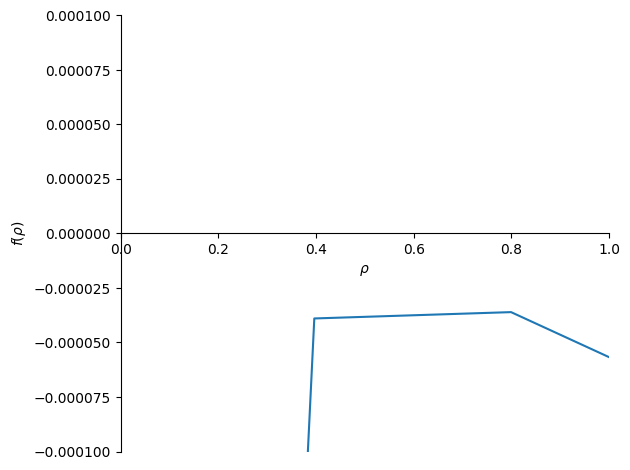

In [209]:
yl = 0.0001
plot(phase_line, xlim = [0, 1], ylim = [-yl, yl])

## Moment matrix

In [210]:
d3q19 = LBStencil(Stencil.D3Q19)
D = len(d3q19[0])
Q = len(d3q19)
c = sp.Matrix(d3q19)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

x, y, z = MOMENT_SYMBOLS
one = sp.core.sympify(1)
c2 = x**2+y**2+z**2
c4 = c2**2

moments = [ 
    one,
    x,
    y,
    z,
    c2-1,
    3*x**2-c2,
    y**2-z**2,
    x*y,
    y*z,
    z*x,
    (3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (z**2-x**2)*y,
    (x**2-y**2)*z,
    3*c4-6*c2+1,
    (2*c2-3)*(3*x**2-c2),
    (2*c2-3)*(y**2-z**2)
]

M = moment_matrix(moments, stencil=d3q19)
N = [ sum([w[i]*M[a,i]**2 for i in range (Q)]) for a in range(Q) ]

## Moment and equilibrium distribution calculation

In [211]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
cs = sp.sqrt(sp.Rational(1,3))
kx, ky, kz = sp.symbols('k_x, k_y, k_z')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ sp.Derivative(rho,a)*sp.Derivative(rho,b) for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
G = kappa*Drho2

five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                              rho(x, y, z)],
[                                                                                                                                                                                                                                                                                                                                                                          u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                  

## Calculation of noise covariance matrix

In [212]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
k, kx, ky, kz = sp.symbols('k, k_x, k_y, k_z')
# k = sp.symbols('k')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ 0 for b in [x,y,z] ] for a in [x,y,z] ])
# D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
D2rho = -k**2*rho
# G = kappa*Drho2
cs = sp.sqrt(sp.Rational(1, 3))
five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                    rho(x, y, z)],
[                                                                                                                                                                                                                                u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                u_y*rho(x, y, z)],
[                                                                                                                                                                                                                                u_z*rho(x, y, z)],
[3*k**2*kappa*r

In [242]:
rho0 = sp.symbols("rho0")
k = sp.symbols('k')
cs = sp.symbols('c_s', real=True, cls=sp.Function)(k)
N_sp = sp.Matrix(N)

fbar = feq.subs({pb:rho*cs**2}).subs({rho:rho0,ux:0,uy:0,uz:0,kappa:0})
S = sp.symbols('S', cls=sp.Function)(k)/rho0*sp.diag(*fbar)
G = sp.simplify(M@S@M.T)
G
# G_mut = sp.Matrix(G)

# for i in range(Q):
#     G_mut[i, i] /= N_sp[i]

# G_mut

Matrix([
[                  S(k),              0,              0,              0, (3*c_s(k)**2 - 1)*S(k),                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0, (1 - 3*c_s(k)**2)*S(k),                0,                  0],
[                     0, S(k)*c_s(k)**2,              0,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0,                      0,                0,                  0],
[                     0,              0, S(k)*c_s(k)**2,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                 

In [243]:
# lb,ls,lq,le = sp.symbols('lambda_b, lambda_s, lambda_q, lambda_e', real = True)
# lambdas = [0]*4 + [lb]*1 + [ls]*5 + [lq]*6 + [lb]*3
d = 3*(cs**2 - sp.Rational(1,3))
l = sp.symbols("lambda")
lambdas = [0]*4 + [l]*1 + [l]*5 + [l]*6 + [l]*3
Lambda = sp.diag(*lambdas)

Lambda[4,0] = -d*lambdas[4]
Lambda[16,0] = d*lambdas[16]

Lambda

Matrix([
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[lambda*(1 - 3*c_s(k)**2), 0, 0, 0, lambda,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0, lambda,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      

In [244]:
A = Lambda # Advection matrix A

Xi = sp.simplify(A@G + G@A.T)
# Xi = sp.simplify(A@G_mut + G_mut@A.T)
# Xi = Xi/sp.Rational(1, 3)
Xi

Matrix([
[0, 0, 0, 0,                                         0,                       0,                         0,                         0,                         0,                         0,                       0,                       0,                       0,                         0,                         0,                         0,                                         0,                       0,                         0],
[0, 0, 0, 0,                                         0,                       0,                         0,                         0,                         0,                         0,                       0,                       0,                       0,                         0,                         0,                         0,                                         0,                       0,                         0],
[0, 0, 0, 0,                                         0,                       0,                         0,  

In [233]:
idx = 17
Xi.diagonal()[idx]

6*lambda*S(k)*c_s(k)**2

In [14]:
N[idx]

1/9

In [15]:
Xi.diagonal()[idx]/N[idx]

6*lambda*S(k)*c_s(k)**2

# Comparing actual versus theoretical values

In [354]:
import yt
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

## Run 1

**Settings**
1. $\rho_v = 0.5$
2. $\rho_l = 1.0$
3. $k_b T = 10^{-7}$
4. $\beta = 0.14$
5. $\kappa = 0$
6. $L = 16$
7. $t = 10^5$

In [495]:
savedir = "b_0.14-k_0-rl_1-rv_0.5/"

### Moment distributions

In [496]:
ts = yt.load(savedir + "hydro_plt*")
L = 16
start = 89
conserved_variables = [('boxlib', 'rho'), ('boxlib', 'ux'), ('boxlib', 'uy'), ('boxlib', 'uz'),
                       ('boxlib', 'pxx'), ('boxlib', 'pyy'), ('boxlib', 'pzz'),
                       ('boxlib', 'pxy'), ('boxlib', 'pxz'), ('boxlib', 'pyz')]
conserved_variables_data = np.zeros((len(conserved_variables), len(ts[start:]), L**3))

for i in range(start, len(ts)):
    ds = ts[i]
    ad = ds.all_data()

    for j, label in enumerate(conserved_variables):
        conserved_variables_data[j, i - start] = ad[label] 

yt : [INFO     ] 2024-07-09 15:10:44,724 Parameters: current_time              = 89000.0
yt : [INFO     ] 2024-07-09 15:10:44,725 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:10:44,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-09 15:10:44,727 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-09 15:10:44,849 Parameters: current_time              = 90000.0
yt : [INFO     ] 2024-07-09 15:10:44,850 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:10:44,850 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-09 15:10:44,851 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-09 15:10:45,015 Parameters: current_time              = 91000.0
yt : [INFO     ] 2024-07-09 15:10:45,016 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:10:45,017 Parameters: domain_left_edge          = [0. 0. 0

From G matrix above, the theoretical value of the variance of the noise can be calculated. The mean of the expected distribution for these variables are as the reference density and velocities, $\rho_0 = 1$, $u_x = u_y = u_z = 0$

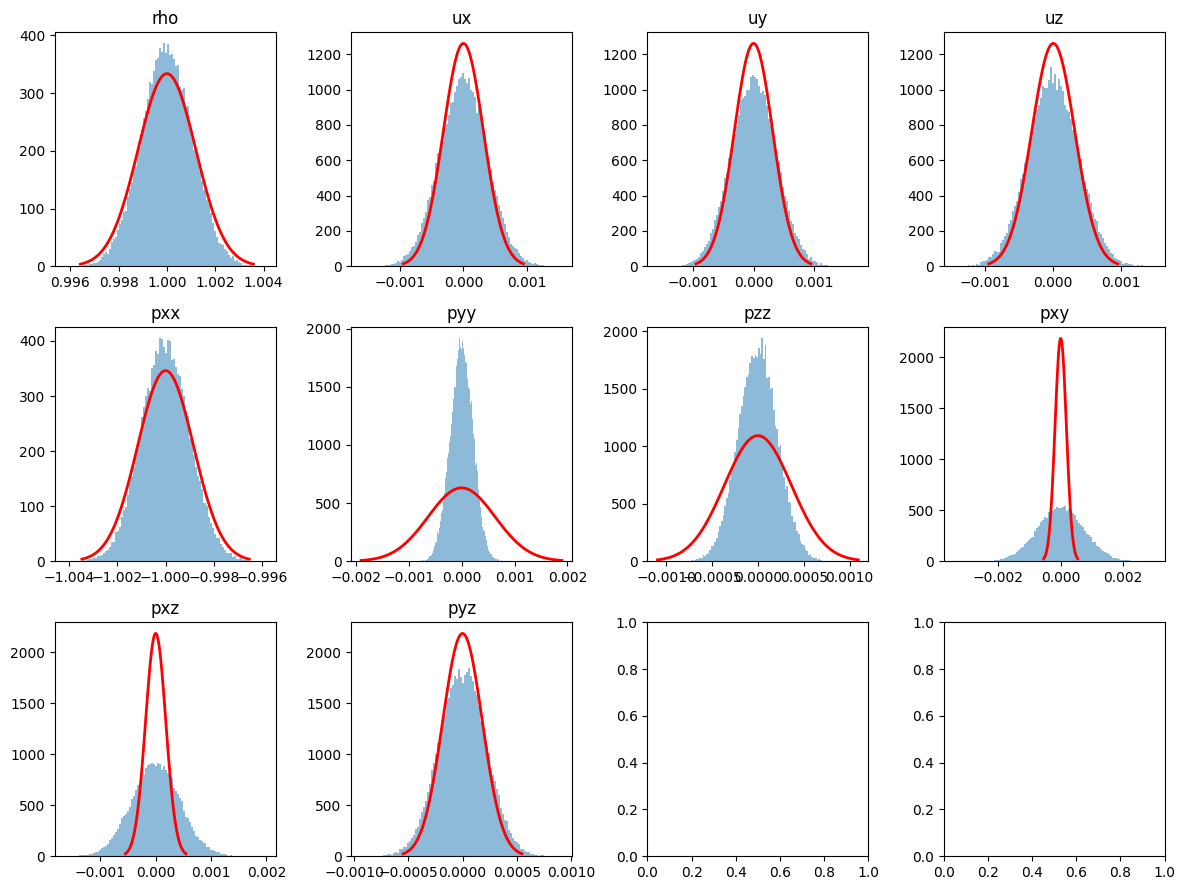

In [497]:
kbt = 1e-7
u0 = 0
cs2 = 1/3
Beta = 0.14
rho_v = 0.5
rho_l = 1.0
rho0 = rho_l

mu_s = [rho0, u0, u0, u0]
mu_s = [rho0] + [u0]*3 + [float(-rho0)] + 5*[0]

# s_k =  kbt*rho0/cs2
# variances = [s_k] + [s_k*cs2]*3 +  [(1 - cs2)*s_k] + [4*s_k*cs2] + [4/3*s_k*cs2] + 3*[1/3*s_k*cs2]
system_cs2 = 2*rho0*Beta*(rho_l - rho_v)**2
s_k =  kbt*rho0/system_cs2
T = kbt*rho0/cs2
variances = [s_k] + [T*cs2]*3 +  [(1 - system_cs2)*s_k] + [4*s_k*system_cs2] + [4/3*s_k*system_cs2] + 3*[1/3*s_k*system_cs2]

n = len(mu_s)
rows = int(np.ceil(n/4))

fig, axs = plt.subplots(rows, 4, figsize = (3*4, rows*3))
axs = axs.flatten()

for i in range(n):
    ax = axs[i]
    ax.hist(conserved_variables_data[i, ...].flatten(), bins = 100, 
            density = True, color = 'tab:blue', alpha = 0.5)

    mu = mu_s[i]
    sigma = np.sqrt(float(variances[i]))
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red', lw = 2)

    ax.set_title(conserved_variables[i][-1])
    # ax.set_xlim([mu - 10*sigma, mu + 10*sigma])

fig.tight_layout()

### Structure factors

In [498]:
ts = yt.load(savedir + "SF_plt_mag*")
ds = ts[-1]
ad = ds.all_data()

yt : [INFO     ] 2024-07-09 15:10:48,934 Parameters: current_time              = 100000.0
yt : [INFO     ] 2024-07-09 15:10:48,934 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:10:48,935 Parameters: domain_left_edge          = [-50.26548246 -50.26548246 -50.26548246]
yt : [INFO     ] 2024-07-09 15:10:48,936 Parameters: domain_right_edge         = [50.26548246 50.26548246 50.26548246]


In [499]:
ds.field_list

[('boxlib', 'struct_fact_rho_rho'),
 ('boxlib', 'struct_fact_rho_ux'),
 ('boxlib', 'struct_fact_rho_uy'),
 ('boxlib', 'struct_fact_rho_uz'),
 ('boxlib', 'struct_fact_ux_ux'),
 ('boxlib', 'struct_fact_ux_uy'),
 ('boxlib', 'struct_fact_ux_uz'),
 ('boxlib', 'struct_fact_uy_uy'),
 ('boxlib', 'struct_fact_uy_uz'),
 ('boxlib', 'struct_fact_uz_uz')]

11.08548169508094 dimensionless


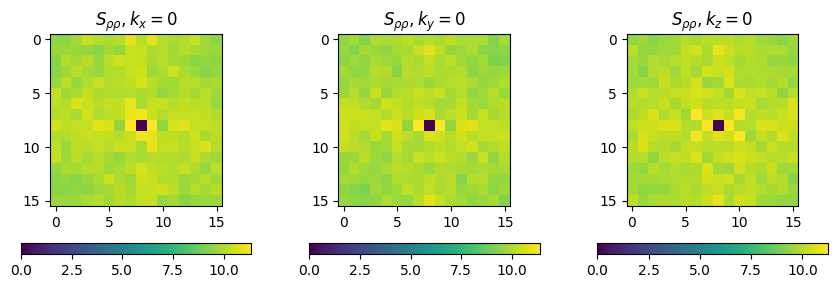

In [500]:
# ad[ds.field_list[0]]
data = ad[ds.field_list[0]].reshape(L, L, L)
print(data.mean())
sz = 3
fig, axs = plt.subplots(1, 3, figsize = (3*sz, sz))

ax = axs[0]
im = ax.imshow(data[L//2])
plt.colorbar(im, ax = ax, orientation = 'horizontal', location = 'bottom', shrink = 0.8)
ax.set_title(r"$S_{\rho\rho}, k_x = 0$")

ax = axs[1]
im = ax.imshow(data[:, L//2, :])
plt.colorbar(im, ax = ax, orientation = 'horizontal', location = 'bottom', shrink = 0.8)
ax.set_title(r"$S_{\rho\rho}, k_y = 0$")

ax = axs[2]
im = ax.imshow(data[..., L//2])
plt.colorbar(im, ax = ax, orientation = 'horizontal', location = 'bottom', shrink = 0.8)
ax.set_title(r"$S_{\rho\rho}, k_z = 0$")

fig.tight_layout()

1.3986892667141477 dimensionless
1.3993405459251709 dimensionless
1.398169942581224 dimensionless
0.05671782357259443 dimensionless
0.056701634902346754 dimensionless
0.05687131343829972 dimensionless


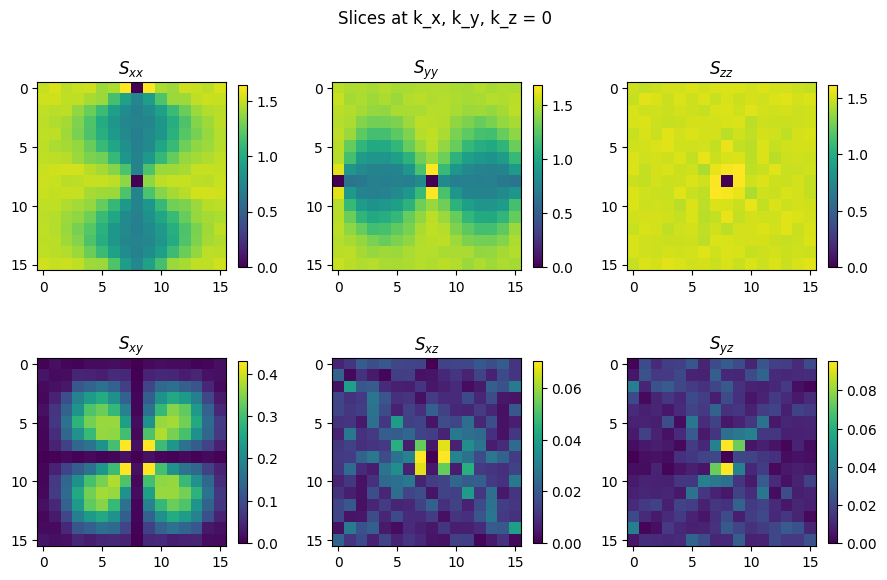

In [501]:
titles = [r"$S_{xx}$", r"$S_{yy}$", r"$S_{zz}$", r"$S_{xy}$", r"$S_{xz}$", r"$S_{yz}$"]

id_s = [('boxlib', 'struct_fact_ux_ux'), ('boxlib', 'struct_fact_uy_uy'), 
          ('boxlib', 'struct_fact_uz_uz'), ('boxlib', 'struct_fact_ux_uy'), 
          ('boxlib', 'struct_fact_ux_uz'), ('boxlib', 'struct_fact_uy_uz')]
 
fig, axs = plt.subplots(2, 3, figsize = (9, 6))
axs = axs.flatten()

for i in range(len(titles)):
    ax = axs[i]
    data = ad[id_s[i]].reshape(L, L, L)
    print(np.mean(data))
    im = ax.imshow(data[:, :, L//2])
    plt.colorbar(im, ax = ax, location = 'right', shrink = 0.7)
    ax.set_title(titles[i])

fig.suptitle("Slices at k_x, k_y, k_z = 0")
fig.tight_layout()

### Equilibration ratios

In [502]:
def add_value(d, key, val):
    if key in d.keys():
        d[key].append(val)
    else:
        d[key] = [val]

    return d 


rho_k = ad[ds.field_list[0]].reshape(L, L, L)
uxx_k = ad[ds.field_list[4]].reshape(L, L, L)
uyy_k = ad[ds.field_list[7]].reshape(L, L, L)
uzz_k = ad[ds.field_list[9]].reshape(L, L, L)

d_r = {}
d_vx = {}
d_vy = {}
d_vz = {}

for i in range(L):
    for j in range(L):
        for k in range(L):
            x = i - L//2 if i < L//2 else  i - L//2
            y = j - L//2 if j < L//2 else  j - L//2
            z = k - L//2 if k < L//2 else  k - L//2

            x /= L//2
            y /= L//2
            z /= L//2
            
            k2 = x**2 + y**2 + z**2

            d_r = add_value(d_r, k2, float(rho_k[i, j, k]))
            d_vx = add_value(d_vx, k2, float(uxx_k[i, j, k]))
            d_vy = add_value(d_vy, k2, float(uyy_k[i, j, k]))
            d_vz = add_value(d_vz, k2, float(uzz_k[i, j, k]))

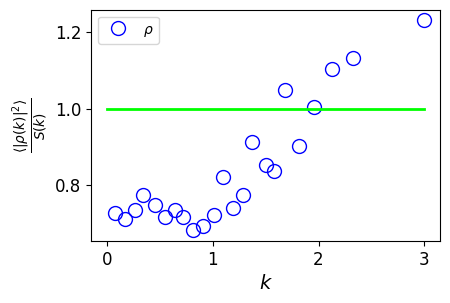

In [503]:
ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

Sk =  kbt*rho0/system_cs2
Sk /= kbt # Structure factor has been rescaled in the code during output
scaling = Sk

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

x = np.array(list(d_r.keys()))
x = np.sort(x)
slc = slice(0, x.size, 5)
x = x[slc]

y = np.zeros(x.size)

for i, k in enumerate(x):
    vals = d_r[k]
    y[i] = np.mean(vals)/scaling

ax.plot(x[1:], y[1:], 
        marker = markers[0], color = colors[0],
        markerfacecolor = "None", markersize = 10, 
        linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()

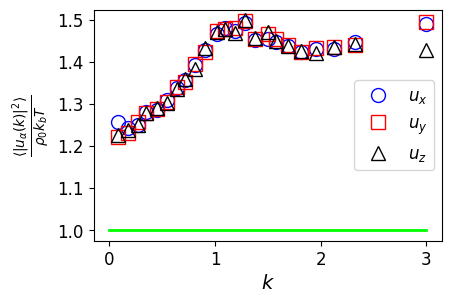

In [504]:
v_s = [d_vx, d_vy, d_vz]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

scaling = rho0

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i in range(3):
    curr_d = v_s[i]
    x = np.array(list(curr_d.keys()))
    x = np.sort(x)
    slc = slice(0, x.size, 5)
    x = x[slc]

    y = np.zeros(x.size)
    for j, k in enumerate(x):
        vals = curr_d[k]
        y[j] = np.mean(vals)/scaling

    ax.plot(x[1:], y[1:], marker = markers[i], markersize = 10, color = colors[i],
            markerfacecolor = "None", linestyle = "None", label = labels[i])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_0 k_bT}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(fontsize = 12)

## Run 2

**Settings**
1. $\rho_v = 0.1$
2. $\rho_l = 1.0$
3. $k_b T = 10^{-7}$
4. $\beta = 0.015$
5. $\kappa = 0$
6. $L = 16$

In [505]:
savedir = "b_0.015-k_0-rl_1-rv_0.1/"

### Moment distributions

In [506]:
ts = yt.load(savedir + "hydro_plt*")
L = 16
start = 89
conserved_variables = [('boxlib', 'rho'), ('boxlib', 'ux'), ('boxlib', 'uy'), ('boxlib', 'uz'),
                       ('boxlib', 'pxx'), ('boxlib', 'pyy'), ('boxlib', 'pzz'),
                       ('boxlib', 'pxy'), ('boxlib', 'pxz'), ('boxlib', 'pyz')]
conserved_variables_data = np.zeros((len(conserved_variables), len(ts[start:]), L**3))

for i in range(start, len(ts)):
    ds = ts[i]
    ad = ds.all_data()

    for j, label in enumerate(conserved_variables):
        conserved_variables_data[j, i - start] = ad[label] 

yt : [INFO     ] 2024-07-09 15:14:37,794 Parameters: current_time              = 89000.0
yt : [INFO     ] 2024-07-09 15:14:37,795 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:14:37,796 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2024-07-09 15:14:37,797 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-09 15:14:37,908 Parameters: current_time              = 90000.0
yt : [INFO     ] 2024-07-09 15:14:37,908 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:14:37,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-09 15:14:37,910 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-09 15:14:38,017 Parameters: current_time              = 91000.0
yt : [INFO     ] 2024-07-09 15:14:38,018 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:14:38,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-09 15:14:38,020 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-09 15:14:38,125 Parameters: current_time              = 92000.0
yt : [INFO     ] 2024-07-09 15:14:38,125 Parameters: domain_dimensions         = [16 16 1

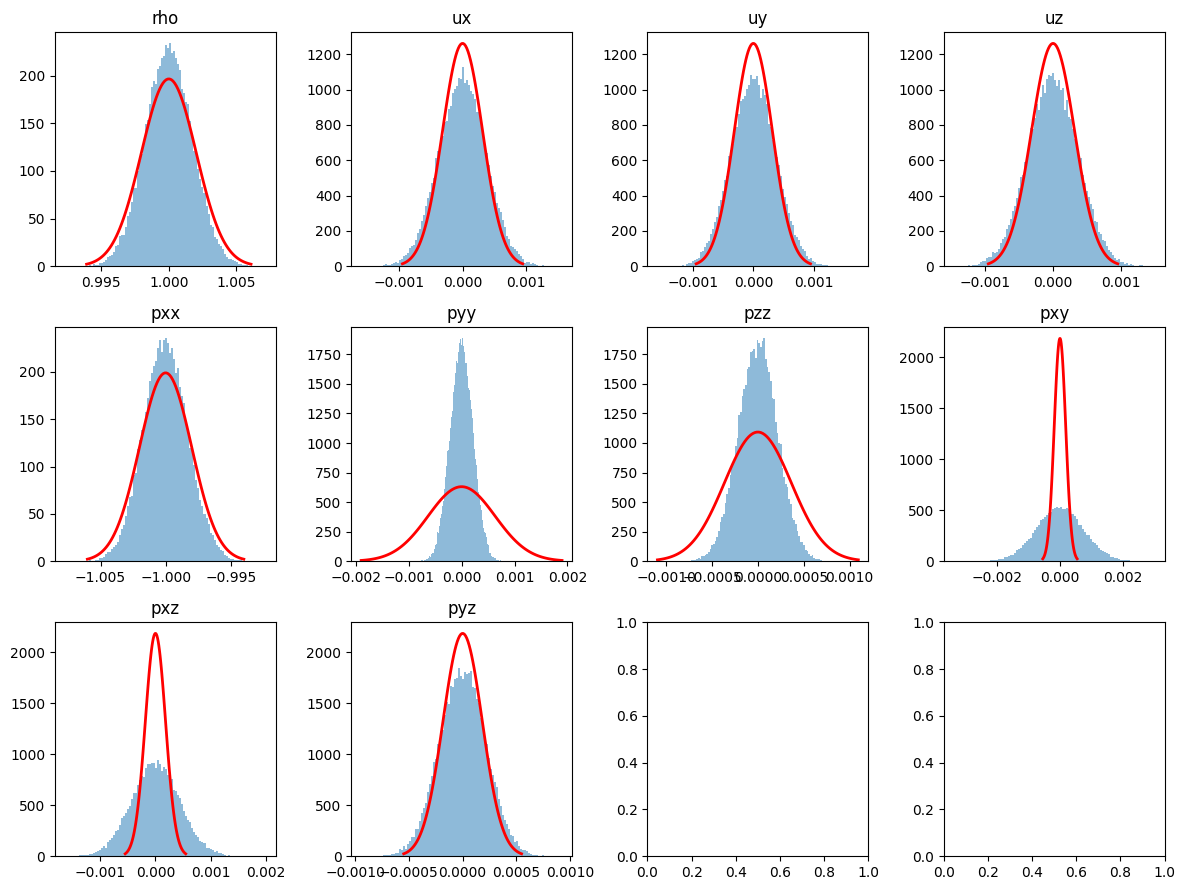

In [507]:
kbt = 1e-7
u0 = 0
cs2 = 1/3
Beta = 0.015
rho_v = 0.1
rho_l = 1.0
rho0 = rho_l

mu_s = [rho0, u0, u0, u0]
mu_s = [rho0] + [u0]*3 + [float(-rho0)] + 5*[0]

# s_k =  kbt*rho0/cs2
# variances = [s_k] + [s_k*cs2]*3 +  [(1 - cs2)*s_k] + [4*s_k*cs2] + [4/3*s_k*cs2] + 3*[1/3*s_k*cs2]
system_cs2 = 2*rho0*Beta*(rho_l - rho_v)**2
s_k =  kbt*rho0/system_cs2
T = kbt*rho0/cs2
variances = [s_k] + [T*cs2]*3 +  [(1 - system_cs2)*s_k] + [4*s_k*system_cs2] + [4/3*s_k*system_cs2] + 3*[1/3*s_k*system_cs2]

n = len(mu_s)
rows = int(np.ceil(n/4))

fig, axs = plt.subplots(rows, 4, figsize = (3*4, rows*3))
axs = axs.flatten()

for i in range(n):
    ax = axs[i]
    ax.hist(conserved_variables_data[i, ...].flatten(), bins = 100, 
            density = True, color = 'tab:blue', alpha = 0.5)

    mu = mu_s[i]
    sigma = np.sqrt(float(variances[i]))
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red', lw = 2)

    ax.set_title(conserved_variables[i][-1])
    # ax.set_xlim([mu - 10*sigma, mu + 10*sigma])

fig.tight_layout()

### Structure factors

In [508]:
ts = yt.load(savedir + "SF_plt_mag*")
ds = ts[-1]
ad = ds.all_data()

yt : [INFO     ] 2024-07-09 15:14:42,329 Parameters: current_time              = 100000.0
yt : [INFO     ] 2024-07-09 15:14:42,329 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-09 15:14:42,330 Parameters: domain_left_edge          = [-50.26548246 -50.26548246 -50.26548246]
yt : [INFO     ] 2024-07-09 15:14:42,331 Parameters: domain_right_edge         = [50.26548246 50.26548246 50.26548246]


30.19917955514262 dimensionless


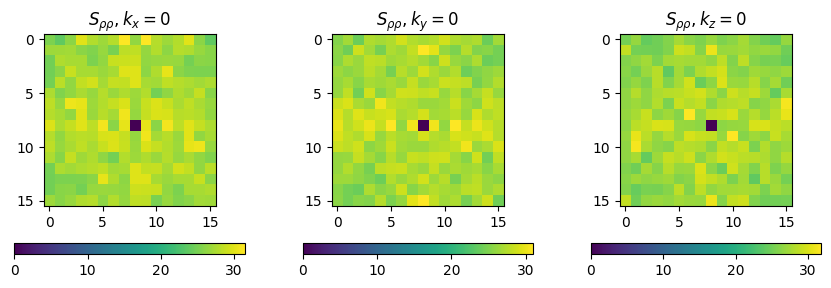

In [509]:
# ad[ds.field_list[0]]
data = ad[ds.field_list[0]].reshape(L, L, L)
print(data.mean())
sz = 3
fig, axs = plt.subplots(1, 3, figsize = (3*sz, sz))

ax = axs[0]
im = ax.imshow(data[L//2])
plt.colorbar(im, ax = ax, orientation = 'horizontal', location = 'bottom', shrink = 0.8)
ax.set_title(r"$S_{\rho\rho}, k_x = 0$")

ax = axs[1]
im = ax.imshow(data[:, L//2, :])
plt.colorbar(im, ax = ax, orientation = 'horizontal', location = 'bottom', shrink = 0.8)
ax.set_title(r"$S_{\rho\rho}, k_y = 0$")

ax = axs[2]
im = ax.imshow(data[..., L//2])
plt.colorbar(im, ax = ax, orientation = 'horizontal', location = 'bottom', shrink = 0.8)
ax.set_title(r"$S_{\rho\rho}, k_z = 0$")

fig.tight_layout()

1.3950972913989035 dimensionless
1.3957343583230366 dimensionless
1.3946093274667128 dimensionless
0.058762942268162165 dimensionless
0.05874788129903305 dimensionless
0.05895885406263861 dimensionless


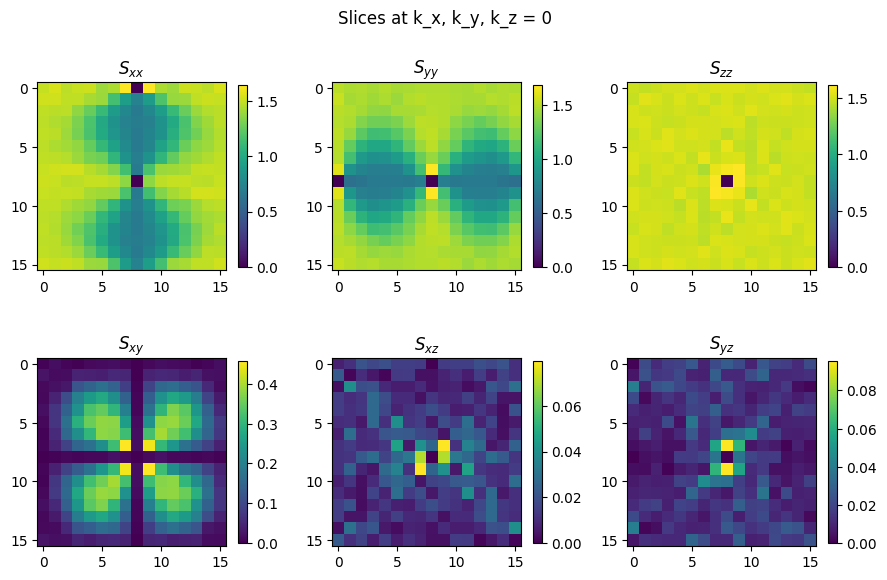

In [510]:
titles = [r"$S_{xx}$", r"$S_{yy}$", r"$S_{zz}$", r"$S_{xy}$", r"$S_{xz}$", r"$S_{yz}$"]

id_s = [('boxlib', 'struct_fact_ux_ux'), ('boxlib', 'struct_fact_uy_uy'), 
          ('boxlib', 'struct_fact_uz_uz'), ('boxlib', 'struct_fact_ux_uy'), 
          ('boxlib', 'struct_fact_ux_uz'), ('boxlib', 'struct_fact_uy_uz')]
 
fig, axs = plt.subplots(2, 3, figsize = (9, 6))
axs = axs.flatten()

for i in range(len(titles)):
    ax = axs[i]
    data = ad[id_s[i]].reshape(L, L, L)
    print(np.mean(data))
    im = ax.imshow(data[:, :, L//2])
    plt.colorbar(im, ax = ax, location = 'right', shrink = 0.7)
    ax.set_title(titles[i])

fig.suptitle("Slices at k_x, k_y, k_z = 0")
fig.tight_layout()

### Equilibration ratios

In [511]:
def add_value(d, key, val):
    if key in d.keys():
        d[key].append(val)
    else:
        d[key] = [val]

    return d 


rho_k = ad[ds.field_list[0]].reshape(L, L, L)
uxx_k = ad[ds.field_list[4]].reshape(L, L, L)
uyy_k = ad[ds.field_list[7]].reshape(L, L, L)
uzz_k = ad[ds.field_list[9]].reshape(L, L, L)

d_r = {}
d_vx = {}
d_vy = {}
d_vz = {}

for i in range(L):
    for j in range(L):
        for k in range(L):
            x = i - L//2 if i < L//2 else  i - L//2
            y = j - L//2 if j < L//2 else  j - L//2
            z = k - L//2 if k < L//2 else  k - L//2

            x /= L//2
            y /= L//2
            z /= L//2
            
            k2 = x**2 + y**2 + z**2

            d_r = add_value(d_r, k2, float(rho_k[i, j, k]))
            d_vx = add_value(d_vx, k2, float(uxx_k[i, j, k]))
            d_vy = add_value(d_vy, k2, float(uyy_k[i, j, k]))
            d_vz = add_value(d_vz, k2, float(uzz_k[i, j, k]))

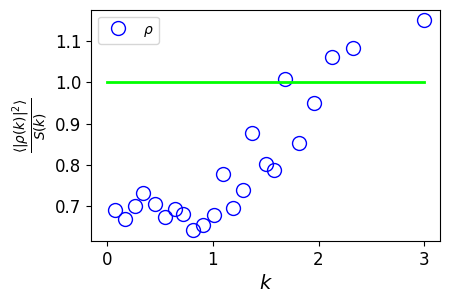

In [512]:
ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

Sk =  kbt*rho0/system_cs2
Sk /= kbt # Structure factor has been rescaled in the code during output
scaling = Sk

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

x = np.array(list(d_r.keys()))
x = np.sort(x)
slc = slice(0, x.size, 5)
x = x[slc]

y = np.zeros(x.size)

for i, k in enumerate(x):
    vals = d_r[k]
    y[i] = np.mean(vals)/scaling

ax.plot(x[1:], y[1:], 
        marker = markers[0], color = colors[0],
        markerfacecolor = "None", markersize = 10, 
        linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()

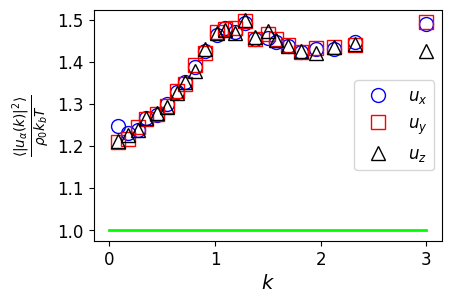

In [513]:
v_s = [d_vx, d_vy, d_vz]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

scaling = rho0

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i in range(3):
    curr_d = v_s[i]
    x = np.array(list(curr_d.keys()))
    x = np.sort(x)
    slc = slice(0, x.size, 5)
    x = x[slc]

    y = np.zeros(x.size)
    for j, k in enumerate(x):
        vals = curr_d[k]
        y[j] = np.mean(vals)/scaling

    ax.plot(x[1:], y[1:], marker = markers[i], markersize = 10, color = colors[i],
            markerfacecolor = "None", linestyle = "None", label = labels[i])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_0 k_bT}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(fontsize = 12)